# VAE Analysis on Food.com Recipes

## Notebook Overview
In this notebook, I analyze the results of a **Variational Autoencoder (VAE)** trained on the **Food.com recipes dataset**. The focus is on understanding the model’s learned representations and training behavior rather than the implementation details.

Specifically, I will:
- **Examine training losses** – track reconstruction loss and KL divergence, including KL annealing.
- **Explore the latent space** – visualize embeddings to see how recipes are organized in the learned space.
- **Check for posterior collapse** – ensure the latent variables carry meaningful information.
- **Perform downstream analyses** – clustering, dimensionality reduction (UMAP), and nearest neighbor searches to investigate recipe similarities.

The model implementation itself is documented separately in a GitHub README.

In [1]:
import sys
import os
import re
import glob
import math
import pickle

sys.path.append('../')  # path to the folder containing the .py file

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from analysis_utils import (
    plot_losses,
    visualize_latent_embeddings,
    check_collapse_diagnostics,
    perform_clustering,
    perform_umap_reduction,
    find_nearest_neighbors,
    perform_pca_reduction,
    plot_training_metrics,
    analyze_cluster_quality, 
    get_cluster_recommendations, 
    plot_cluster_quality
)

In [2]:
# Set the output path
def get_output_path(working_dir):
    embeds_path = os.path.join(working_dir, "output_embeds/")
    loss_path = os.path.join(working_dir, "output_loss/")
    checkpoints_path = os.path.join(working_dir, "output_checkpoints/")
    test_indices_path = os.path.join(working_dir, "output_indices/")
    analysis_output_path = os.path.join(working_dir, "output_analysis")

    return embeds_path, loss_path, checkpoints_path, test_indices_path, analysis_output_path

In [3]:
# Output and input paths
working_dir = "/Users/fahimeh/Projects/Data_science_prep/Recipe_Recommender_System/vae_with_kl_annealing/"
embeds_path, loss_path, checkpoints_path, test_indices_path, analysis_output_path = get_output_path(working_dir)

input_data_path = "/Users/fahimeh/Projects/Data_science_prep/Recipe_Recommender_System/input_data"

## 1. Load Model input 
Here we first load the input model dataframe becasue we need original recipes to do some analysis. For this we import the test data indices that we saved before and then extract the corresponding recipes from the original data frame

In [4]:
# The embedding model that was used to embed the recipes texts
model_name = "all-MiniLM-L6-v2"

# 1. Load the original NPZ file (with the necessary pickle flag)
data = np.load(os.path.join(input_data_path, f'{model_name}_vae_input_data.npz'), allow_pickle=True)

# 2. Convert the 'recipes' array back into a DataFrame
recipes = pd.DataFrame(data['recipes'])

# 3. Load the test indices saved by train.py
test_indices = np.load(os.path.join(test_indices_path, f"{model_name}_test_indices.npy"))

# 4. Filter the full DataFrame using the indices, and drop the extraneous column
test_recipes = recipes.iloc[test_indices].reset_index()

In [5]:
test_recipes.head()

index  RecipeId                               Name  AuthorId  \
0  149343    161347                     Butter Rum Yum    209747   
1  217915    233237         Maple Dill Chicken Breasts     25063   
2  360812    382554           Paula Deen Santa Fe Wrap    748565   
3  510580    541006  Delectable Company Mac and Cheese     28815   
4   73000     80640        Raisin-Pecan Ginger Muffins     37779   

           AuthorName         DatePublished  RecipeCategory  \
0  Mamas Kitchen Hope  2006-03-24T15:22:00Z       Breakfast   
1              Helen1  2007-06-07T23:01:00Z  Chicken Breast   
2        cookin_nurse  2009-07-23T01:42:00Z       < 15 Mins   
3             CatRep2  2020-09-25T21:48:00Z       < 30 Mins   
4     ratherbeswimmin  2004-01-10T19:59:00Z    Quick Breads   

                               RecipeIngredientParts  Calories  FatContent  \
0  c("sweetened flaked coconut", "ground ginger",...     558.6        24.6   
1  c("boneless chicken breasts", "butter", "salt"...     317.4        15.3   
2  c("cream cheese", "sour cream", "green chilies...     226.5        21.2   
3  c("elbow macaroni", "butter", "all-purpose flo...     634.7        41.3   
4  c("all-purpose flour", "baking soda", "salt", ...    2103.0        73.2   

   SaturatedFatContent  CholesterolContent  SodiumContent  \
0                 15.1               121.2          519.0   
1                  5.1                97.8          253.1   
2                 12.8                58.4          268.6   
3                 24.7               123.1          811.1   
4                 30.0               252.6         2161.2   

   CarbohydrateContent  FiberContent  SugarContent  ProteinContent  \
0                 73.2           2.8          34.3            11.2   
1                  7.6           0.1           6.2            30.3   
2                  4.0           0.7           0.8             6.2   
3                 44.9           2.0           3.2            21.3   
4                343.9          10.0         159.4            29.5   

                                  RecipeInstructions  
0  c("Preheat oven to 350°F.", "In a blender or f...  
1  c("Salt and pepper chicken breasts.", "Melt bu...  
2  c("In a large bowl, beat cream cheese until cr...  
3  c("1.  Cook macaroni according to package dire...  
4  c("Add the first 4 ingredients to a bowl; stir...

In [10]:
test_recipes.columns

Index(['index', 'RecipeId', 'Name', 'AuthorId', 'AuthorName', 'DatePublished',
       'RecipeCategory', 'RecipeIngredientParts', 'Calories', 'FatContent',
       'SaturatedFatContent', 'CholesterolContent', 'SodiumContent',
       'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent',
       'RecipeInstructions'],
      dtype='object')

## 2. Load model outputs
### 2.1 Lets look at the loss for the numeic and text data

In [6]:
# Match all relevant CSVs
files = glob.glob(os.path.join(loss_path, "all-MiniLM-L6-v2_wt*_wn*_kl*_full_loss_history.csv"))

dfs = []
for file in files:
    df = pd.read_csv(file)

    # Extract numeric values from filename using regex
    match = re.search(r"wt([\d.]+)_wn(\d+)_kl([\d.]+)", os.path.basename(file))
    if match:
        wt = float(match.group(1))
        wn = int(match.group(2))
        kl = float(match.group(3))
    else:
        wt = wn = kl = None  # fallback if pattern not matched

    dfs.append(df)

# Combine all
combined_df = pd.concat(dfs, ignore_index=True)

print(combined_df.shape)
combined_df.head()

(900, 10)


epoch  kl_weight  train_loss  val_loss  train_recon_num  train_recon_text  \
0      1        0.0   55.078513  6.484340         0.985559          0.580059   
1      2        0.0    5.893369  5.467660         0.019287          0.492902   
2      3        0.0    5.205254  4.956805         0.012081          0.460120   
3      4        0.0    4.849878  5.164599         0.009018          0.439896   
4      5        0.0    4.664375  4.585558         0.007087          0.431000   

   train_kl_loss  WEIGHT_TEXT  WEIGHT_NUMERIC  FINAL_KL_WEIGHT  
0     200.178966         10.0            50.0              0.1  
1     287.367767         10.0            50.0              0.1  
2     298.773117         10.0            50.0              0.1  
3     303.656788         10.0            50.0              0.1  
4     303.103328         10.0            50.0              0.1

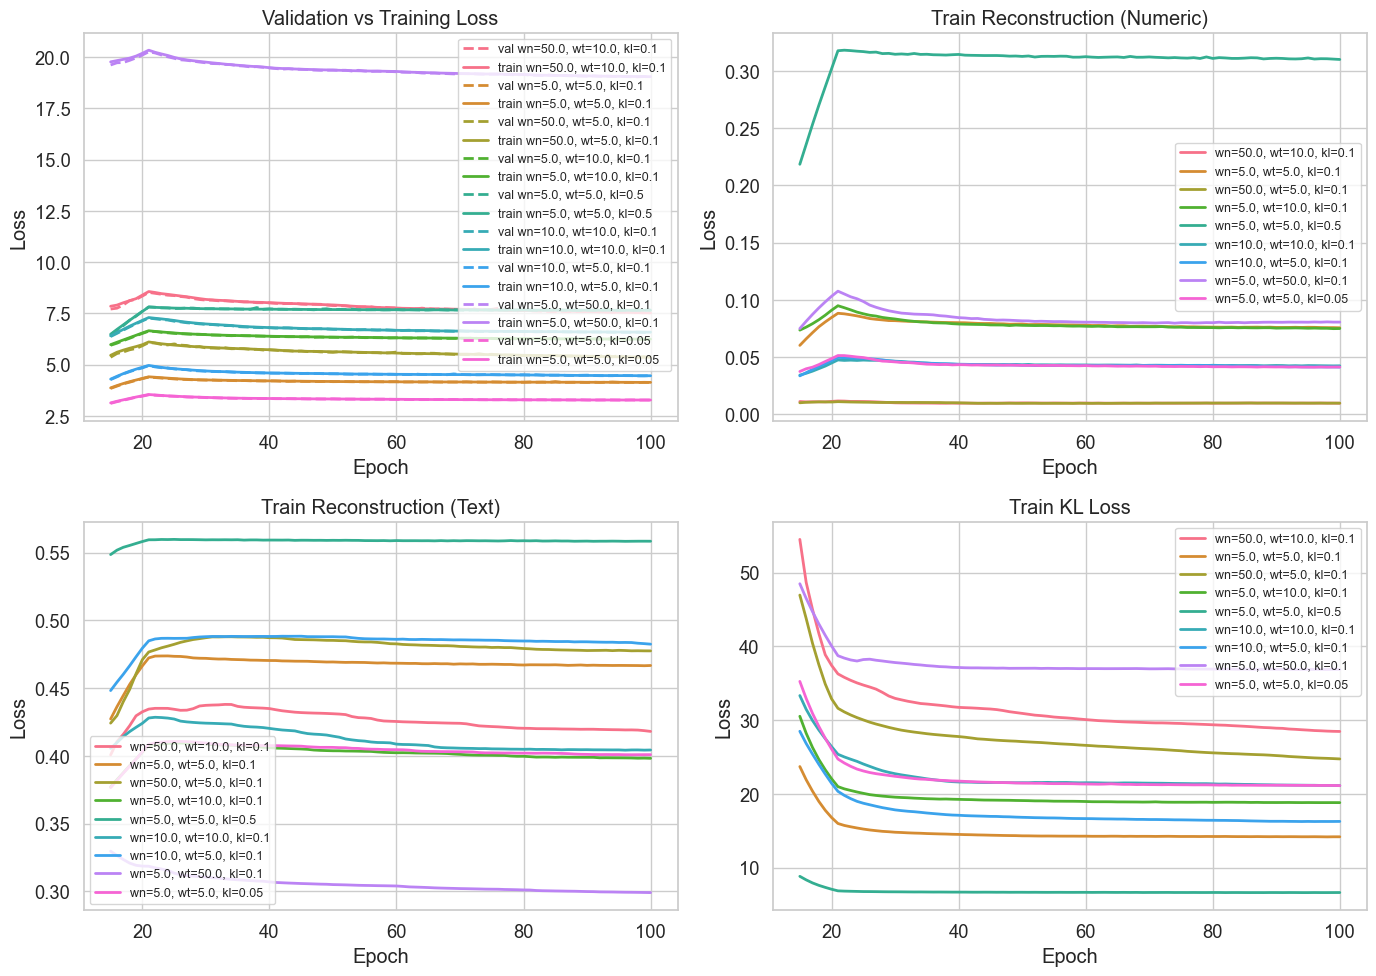

In [7]:
plot_training_metrics(combined_df, min_epoch=15)

### VAE Loss Function

The model is trained using a weighted **VAE loss**, which combines three components:  

$$
\mathcal{L}_{\text{total}} = 
\frac{1}{N} \Big(
w_{\text{num}} \cdot \mathcal{L}_{\text{recon}}^{\text{num}} +
w_{\text{text}} \cdot \mathcal{L}_{\text{recon}}^{\text{text}} +
w_{\text{KL}} \cdot \mathcal{L}_{\text{KL}}
\Big)
$$

where:  

- $\mathcal{L}_{\text{recon}}^{\text{num}} = \|x_{\text{num}} - \hat{x}_{\text{num}}\|^2$  
- $\mathcal{L}_{\text{recon}}^{\text{text}} = \|x_{\text{text}} - \hat{x}_{\text{text}}\|^2$  
- $\mathcal{L}_{\text{KL}} = -\frac{1}{2} \sum (1 + \log \sigma^2 - \mu^2 - \sigma^2)$  
- $w_{\text{num}}, w_{\text{text}}, w_{\text{KL}}$ are the numeric, text, and KL weights respectively  
- $N$ is the batch size

---

### Interpretation

From the loss plots:  
- Increasing **`numeric_weight`** ($w_{\text{num}}$) reduces the numeric reconstruction loss  
- Increasing **`text_weight`** ($w_{\text{text}}$) reduces the text reconstruction loss  
- Increasing **`kl_weight`** ($w_{\text{KL}}$) decreases the KL divergence loss  

These trends confirm that the model behaves as expected — each loss component responds appropriately to its weight, indicating stable and interpretable training dynamics.

### 2.2 Checking posterior collapse

In [8]:
import pandas as pd
import glob, os, re

# Find all *_mu.npy files
mu_files = glob.glob(os.path.join(embeds_path, "all-MiniLM-L6-v2_wt*_wn*_kl*_test_data_latent_embeddings_mu.npy"))

all_results = []

for mu_file in sorted(mu_files):
    # Find the corresponding logvar file
    logvar_file = mu_file.replace("_mu.npy", "_logvar.npy")

    if not os.path.exists(logvar_file):
        print(f"⚠️ Missing logvar file for {os.path.basename(mu_file)}")
        continue

    # Extract numeric values from filename
    match = re.search(r"wt([\d.]+)_wn([\d.]+)_kl([\d.]+)", os.path.basename(mu_file))
    if match:
        wt = float(match.group(1))
        wn = float(match.group(2))
        kl = float(match.group(3))
    else:
        wt = wn = kl = None

    # Use your diagnostic function and collect stats
    stats = check_collapse_diagnostics(mu_file, logvar_file)
    if stats is not None:
        stats.update({'wt': wt, 'wn': wn, 'kl': kl, 'file': os.path.basename(mu_file)})
        all_results.append(stats)

# Create a DataFrame with all results
df_collapse_stats = pd.DataFrame(all_results)

df_collapse_stats

num_samples  latent_dim   mu_mean    mu_std                       mu_check  \
0        76642          32 -0.004456  0.678841                        Healthy   
1        76642          32 -0.001338  0.683020                        Healthy   
2        76642          32 -0.002063  0.677462                        Healthy   
3        76642          32 -0.002556  0.544681                        Healthy   
4        76642          32  0.009063  0.567359                        Healthy   
5        76642          32 -0.001930  0.681952                        Healthy   
6        76642          32 -0.005792  0.547176                        Healthy   
7        76642          32 -0.001929  0.386329  Caution: compact latent space   
8        76642          32 -0.003277  0.853818                        Healthy   

   logvar_std  logvar_avg_variance logvar_check    wt    wn    kl  \
0    1.716757             0.532585      Healthy  10.0  10.0  0.10   
1    2.398969             0.529685      Healthy  10.0  50.0  0.10   
2    1.477540             0.533227      Healthy  10.0   5.0  0.10   
3    1.805026             0.696147      Healthy   5.0  10.0  0.10   
4    2.548428             0.668790      Healthy   5.0  50.0  0.10   
5    1.712934             0.527088      Healthy   5.0   5.0  0.05   
6    1.558291             0.696900      Healthy   5.0   5.0  0.10   
7    1.048388             0.848051      Healthy   5.0   5.0  0.50   
8    1.434604             0.249481      Healthy  50.0   5.0  0.10   

                                                file  
0  all-MiniLM-L6-v2_wt10.0_wn10_kl0.10_test_data_...  
1  all-MiniLM-L6-v2_wt10.0_wn50_kl0.10_test_data_...  
2  all-MiniLM-L6-v2_wt10.0_wn5_kl0.10_test_data_l...  
3  all-MiniLM-L6-v2_wt5.0_wn10_kl0.10_test_data_l...  
4  all-MiniLM-L6-v2_wt5.0_wn50_kl0.10_test_data_l...  
5  all-MiniLM-L6-v2_wt5.0_wn5_kl0.05_test_data_la...  
6  all-MiniLM-L6-v2_wt5.0_wn5_kl0.10_test_data_la...  
7  all-MiniLM-L6-v2_wt5.0_wn5_kl0.50_test_data_la...  
8  all-MiniLM-L6-v2_wt50.0_wn5_kl0.10_test_data_l...

It is clear that only one of the runs with higher kl weight is showing kind of posterior collapse

### 2.3 Checking the latent space representation

Applying K-Means clustering (k=6) on 76642 samples...
Clustering complete.
Applying UMAP reduction (32D -> 2D) on 76642 samples...


/Users/fahimeh/miniconda3/envs/recipe/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP completed in 54.34 seconds.
Applying K-Means clustering (k=6) on 76642 samples...
Clustering complete.
Applying UMAP reduction (32D -> 2D) on 76642 samples...


/Users/fahimeh/miniconda3/envs/recipe/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP completed in 45.83 seconds.
Applying K-Means clustering (k=6) on 76642 samples...
Clustering complete.
Applying UMAP reduction (32D -> 2D) on 76642 samples...


/Users/fahimeh/miniconda3/envs/recipe/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP completed in 43.15 seconds.
Applying K-Means clustering (k=6) on 76642 samples...
Clustering complete.
Applying UMAP reduction (32D -> 2D) on 76642 samples...


/Users/fahimeh/miniconda3/envs/recipe/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP completed in 44.08 seconds.
Applying K-Means clustering (k=6) on 76642 samples...
Clustering complete.
Applying UMAP reduction (32D -> 2D) on 76642 samples...


/Users/fahimeh/miniconda3/envs/recipe/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP completed in 41.43 seconds.
Applying K-Means clustering (k=6) on 76642 samples...
Clustering complete.
Applying UMAP reduction (32D -> 2D) on 76642 samples...


/Users/fahimeh/miniconda3/envs/recipe/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP completed in 42.35 seconds.
Applying K-Means clustering (k=6) on 76642 samples...
Clustering complete.
Applying UMAP reduction (32D -> 2D) on 76642 samples...


/Users/fahimeh/miniconda3/envs/recipe/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP completed in 41.62 seconds.
Applying K-Means clustering (k=6) on 76642 samples...
Clustering complete.
Applying UMAP reduction (32D -> 2D) on 76642 samples...


/Users/fahimeh/miniconda3/envs/recipe/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP completed in 41.59 seconds.
Applying K-Means clustering (k=6) on 76642 samples...
Clustering complete.
Applying UMAP reduction (32D -> 2D) on 76642 samples...


/Users/fahimeh/miniconda3/envs/recipe/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP completed in 39.28 seconds.
Processed and stored 9 runs in Z_dict.


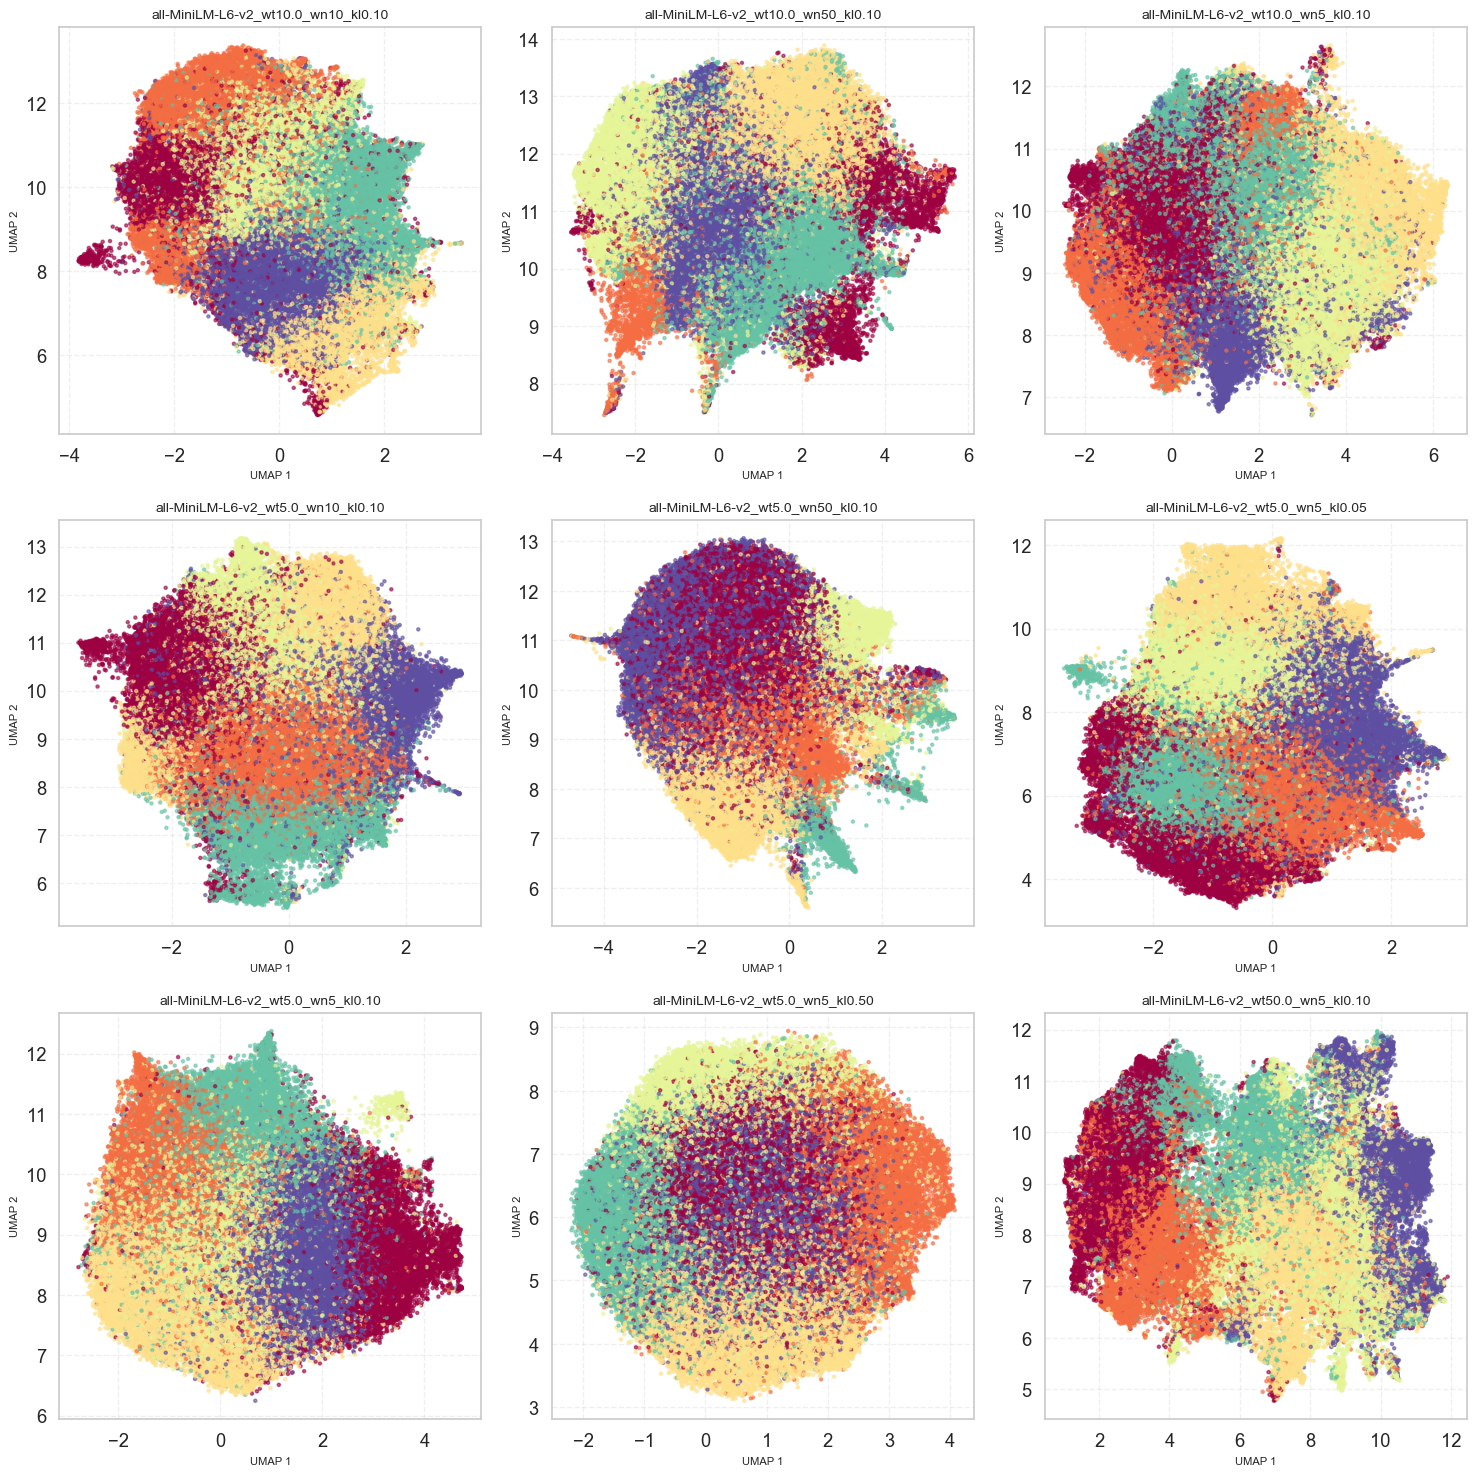

In [9]:
Z_dict = {}          # to store Z_32D and Z_2D_umap for each run
cluster_dict = {}    # to store cluster labels

# Find all latent vector files
latent_files = glob.glob(os.path.join("output_embeds", "all-MiniLM-L6-v2_wt*_wn*_kl*_test_data_latent_embeddings_latent_vectors.npy"))

N_CLUSTER = 6

# === Process each run ===
for latent_file in sorted(latent_files):
    run_name = os.path.basename(latent_file).replace("_test_data_latent_embeddings_latent_vectors.npy", "")

    # Load latent vectors
    Z_32D = np.load(latent_file)

    # Perform clustering
    test_cluster_labels = perform_clustering(Z_32D, n_clusters=N_CLUSTER)

    # Dimensionality reduction (UMAP)
    Z_2D_umap = perform_umap_reduction(Z_32D)

    # Store results
    Z_dict[run_name] = {'Z_32D': Z_32D, 'Z_2D_umap': Z_2D_umap}
    cluster_dict[run_name] = test_cluster_labels

print(f"Processed and stored {len(Z_dict)} runs in Z_dict.")

n_runs = len(Z_dict)
cols = 3
rows = math.ceil(n_runs / cols)
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for i, (run_name, data) in enumerate(Z_dict.items()):
    Z_2D = data['Z_2D_umap']
    labels = cluster_dict[run_name]
    scatter = visualize_latent_embeddings(axes[i], Z_2D, labels, N_CLUSTER, title=run_name)

# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:

# try:
#     # Attempt to access the variables that should be in your environment
#     if 'Z_dict' not in globals() or 'cluster_dict' not in globals():
#         raise NameError("Z_dict or cluster_dict not found.")

#     # 1. Create the output directory if it doesn't exist
#     if not os.path.exists(analysis_output_path):
#         os.makedirs(analysis_output_path)
#         print(f"Created directory: {analysis_output_path}")

#     # 2. Save Z_dict
#     z_dict_path = os.path.join(analysis_output_path, 'Z_dict.pkl')
#     with open(z_dict_path, 'wb') as f:
#         pickle.dump(Z_dict, f)
#     print(f"Successfully saved Z_dict to {z_dict_path} (Size: {sys.getsizeof(Z_dict) / (1024*1024):.2f} MB)")

#     # 3. Save cluster_dict
#     cluster_dict_path = os.path.join(analysis_output_path, 'cluster_dict.pkl')
#     with open(cluster_dict_path, 'wb') as f:
#         pickle.dump(cluster_dict, f)
#     print(f"Successfully saved cluster_dict to {cluster_dict_path} (Size: {sys.getsizeof(cluster_dict) / (1024*1024):.2f} MB)")

# except NameError as e:
#     print(f"\nERROR: Could not find your data objects. Please ensure 'Z_dict' and 'cluster_dict' are defined in your environment before running this script.")
#     print("Specifically, the error was:", e)
    


Created directory: /Users/fahimeh/Projects/Data_science_prep/Recipe_Recommender_System/vae_with_kl_annealing/output_analysis
Successfully saved Z_dict to /Users/fahimeh/Projects/Data_science_prep/Recipe_Recommender_System/vae_with_kl_annealing/output_analysis/Z_dict.pkl (Size: 0.00 MB)
Successfully saved cluster_dict to /Users/fahimeh/Projects/Data_science_prep/Recipe_Recommender_System/vae_with_kl_annealing/output_analysis/cluster_dict.pkl (Size: 0.00 MB)


In [6]:
# Save the results amd load them when needed
with open(os.path.join(analysis_output_path, 'Z_dict.pkl'), 'rb') as f:
    Z_dict= pickle.load(f)
with open(os.path.join(analysis_output_path,'cluster_dict.pkl'), 'rb') as f:
    cluster_dict = pickle.load(f)

Here we perform some statistics on the clusters for each run to decide which of the above models is better. For that we compute the mean and std of the numeric features within each cluster. To see how different clusters are from the numeric point of view

In [7]:
profile_table = {}
for k, v in cluster_dict.items():
    profile_table[k] = analyze_cluster_quality(k, 
                            Z_dict[k]['Z_32D'], 
                            cluster_dict[k], 
                            test_recipes)#)

In [8]:
profile_table.keys()

dict_keys(['all-MiniLM-L6-v2_wt10.0_wn10_kl0.10', 'all-MiniLM-L6-v2_wt10.0_wn50_kl0.10', 'all-MiniLM-L6-v2_wt10.0_wn5_kl0.10', 'all-MiniLM-L6-v2_wt5.0_wn10_kl0.10', 'all-MiniLM-L6-v2_wt5.0_wn50_kl0.10', 'all-MiniLM-L6-v2_wt5.0_wn5_kl0.05', 'all-MiniLM-L6-v2_wt5.0_wn5_kl0.10', 'all-MiniLM-L6-v2_wt5.0_wn5_kl0.50', 'all-MiniLM-L6-v2_wt50.0_wn5_kl0.10'])

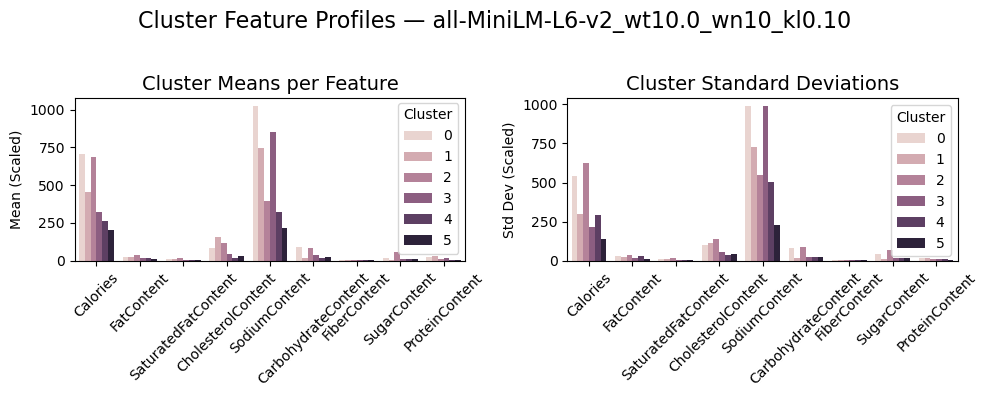

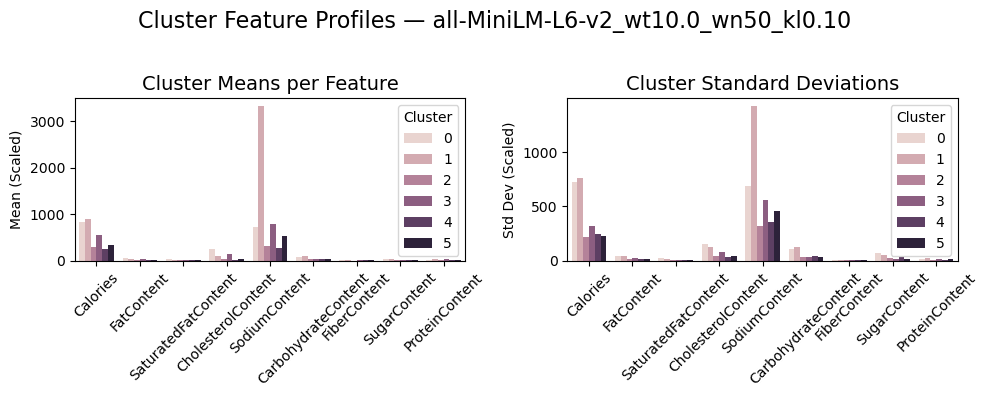

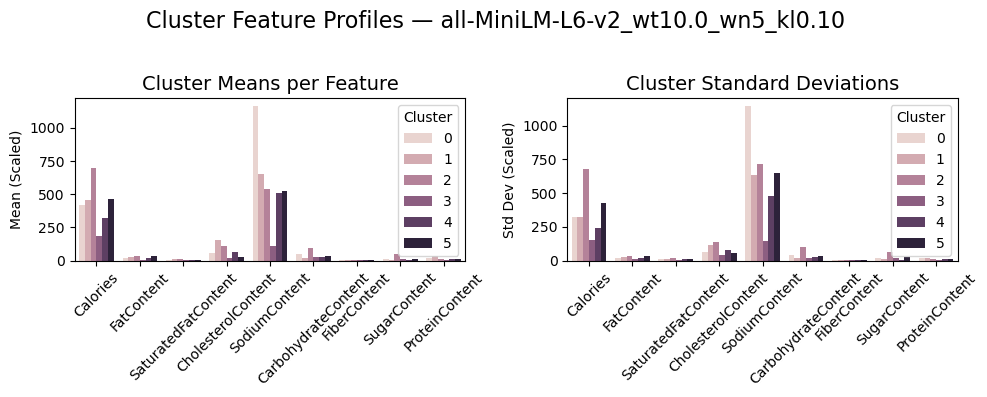

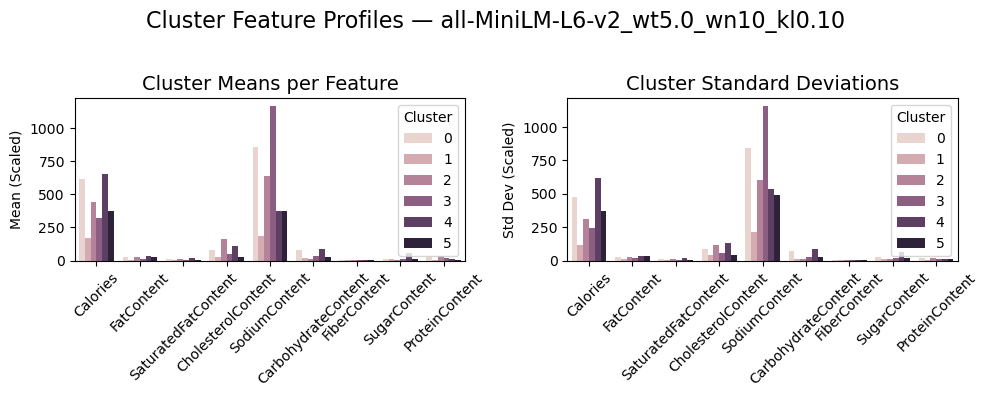

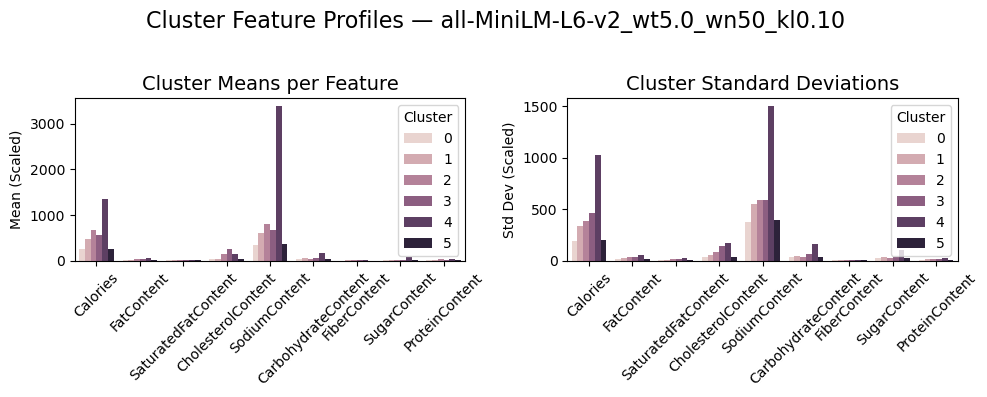

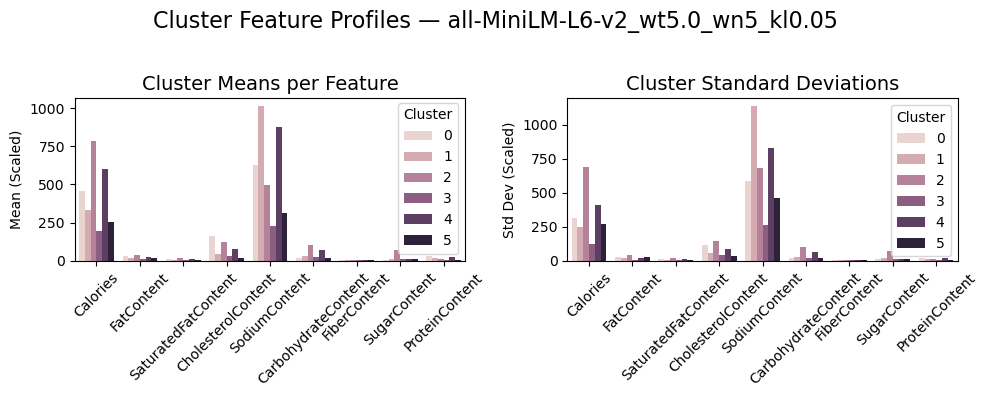

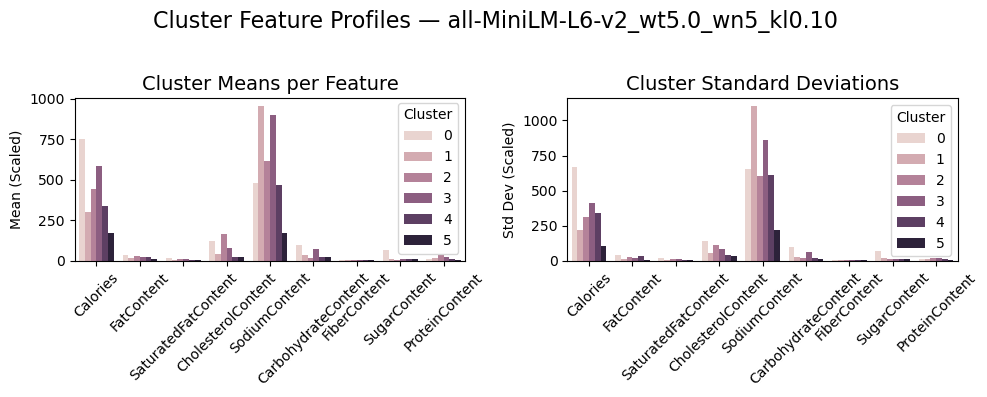

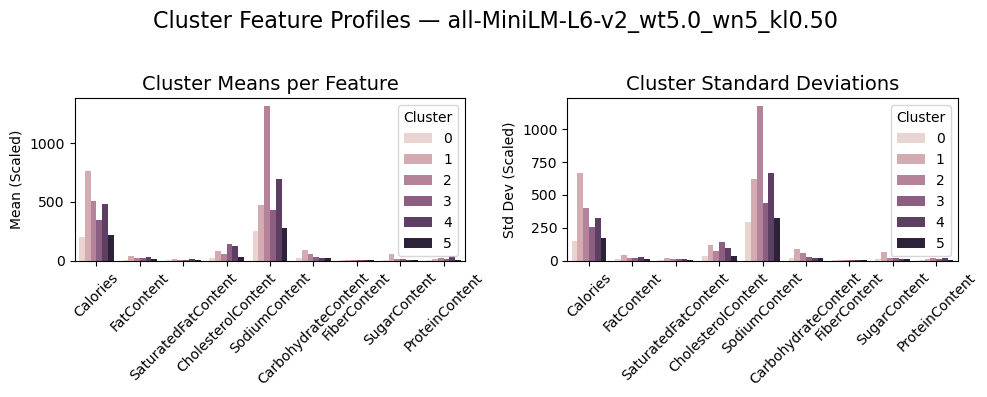

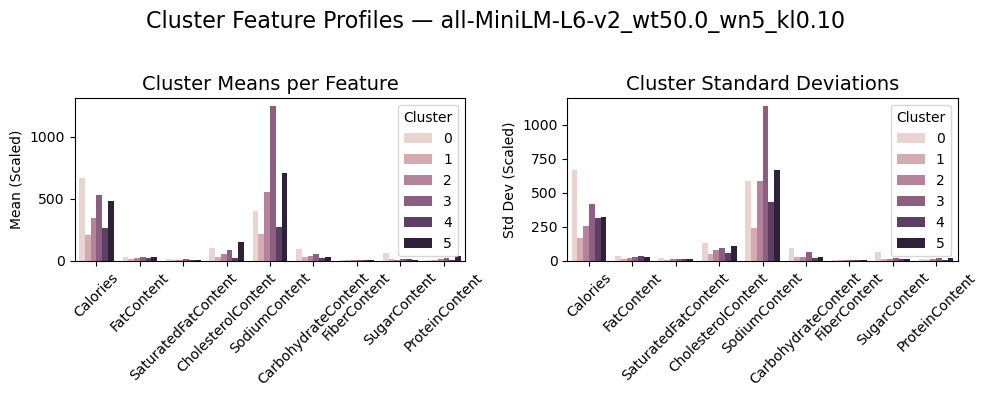

In [9]:
for name, res in profile_table.items():
    plot_cluster_quality(res, name)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_all_clusters_top5_row(profile_table, run_name):
    """
    Plots the top-5 member profiles for all clusters of a given run
    in a single horizontal row of subplots.
    """
    top_members = profile_table[run_name]['top5_members']
    n_clusters = len(top_members)

    fig, axes = plt.subplots(1, n_clusters, figsize=(6*n_clusters, 5), sharey=True)
    if n_clusters == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        profiles_df = top_members[i]['profiles'].copy()
        profiles_df.columns = [f"Top{j+1}" for j in range(profiles_df.shape[1])]
        df = profiles_df.reset_index().rename(columns={'index': 'Feature'})
        df_melted = df.melt(id_vars='Feature', var_name='Member', value_name='Value')

        sns.barplot(
            data=df_melted,
            x='Feature',
            y='Value',
            hue='Member',
            palette='Spectral',
            ax=ax
        )

        ax.set_title(f'Cluster {i}', fontsize=13)
        ax.set_xlabel('')
        ax.tick_params(axis='x', rotation=45)
        if i == 0:
            ax.set_ylabel('Value')
        else:
            ax.set_ylabel('')
        ax.legend().remove()

    plt.suptitle(f'Top-5 Member Profiles per Cluster ({run_name})', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

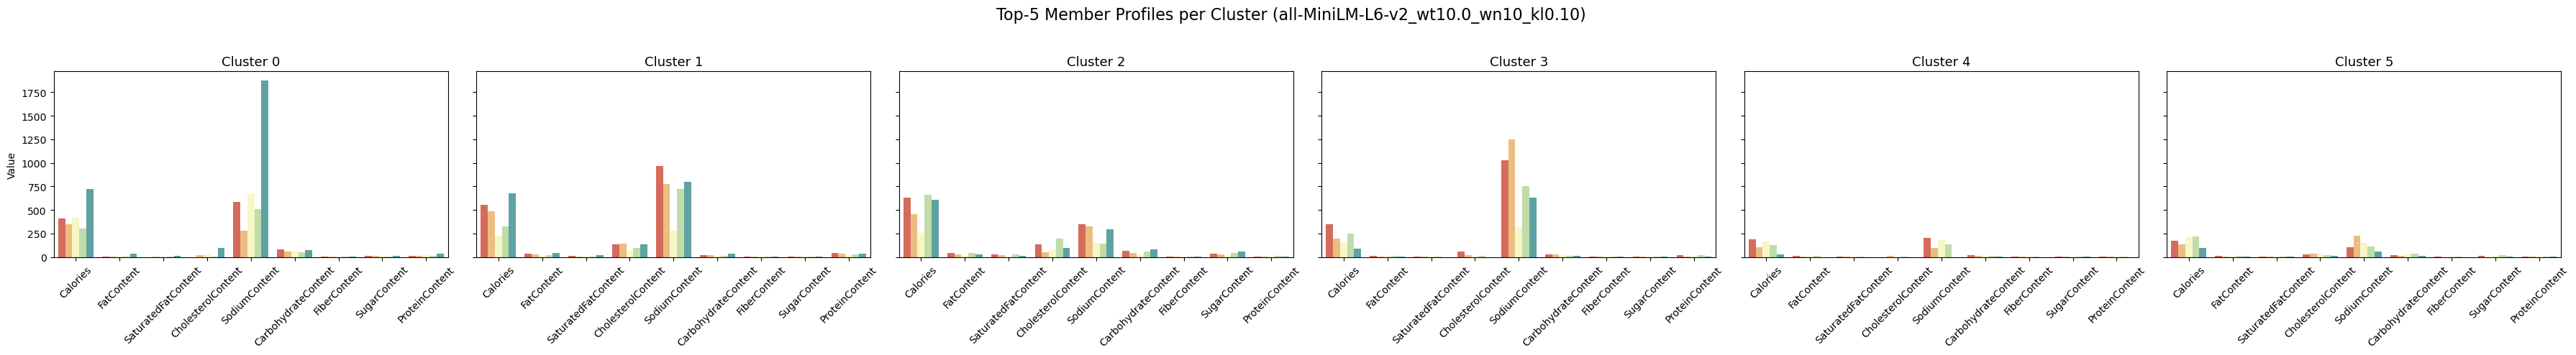

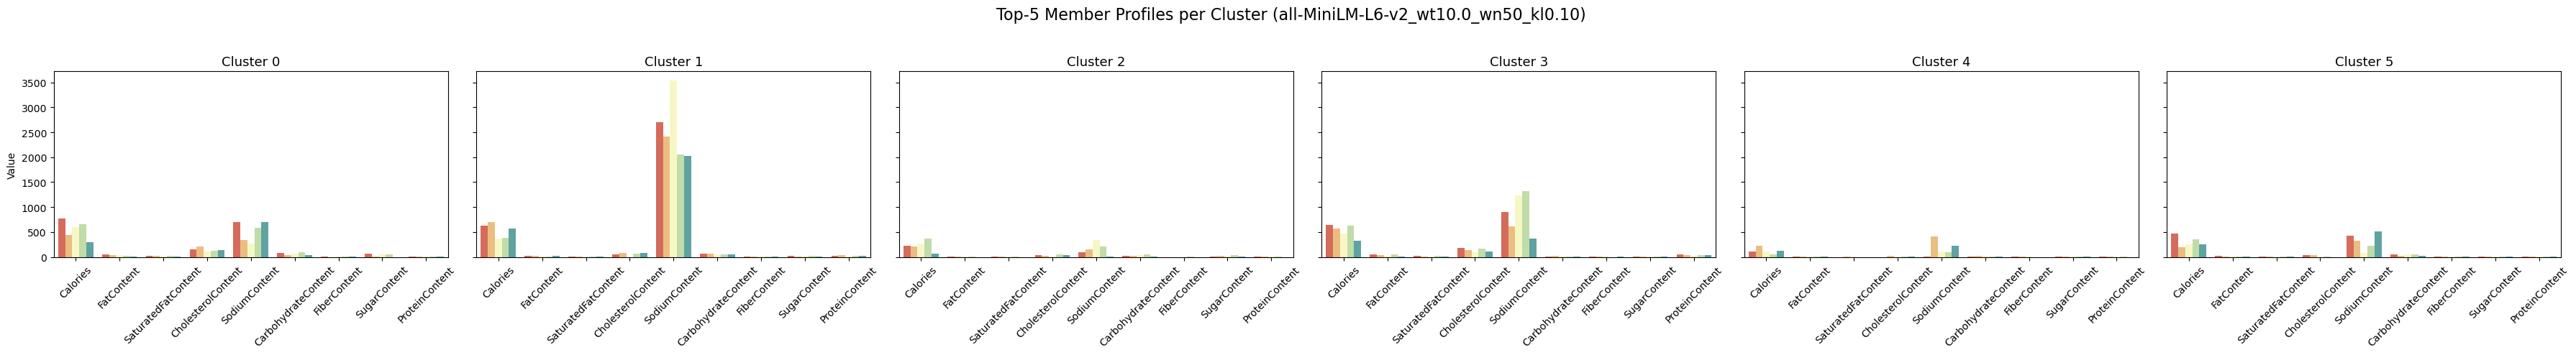

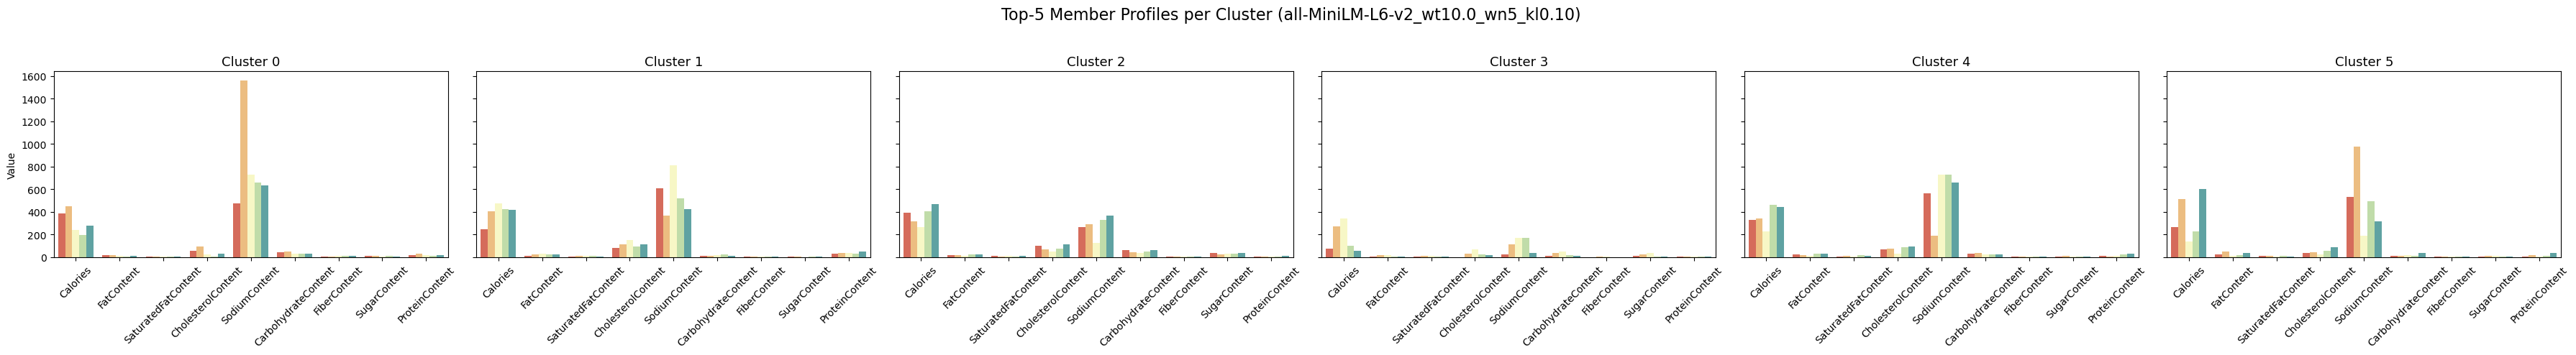

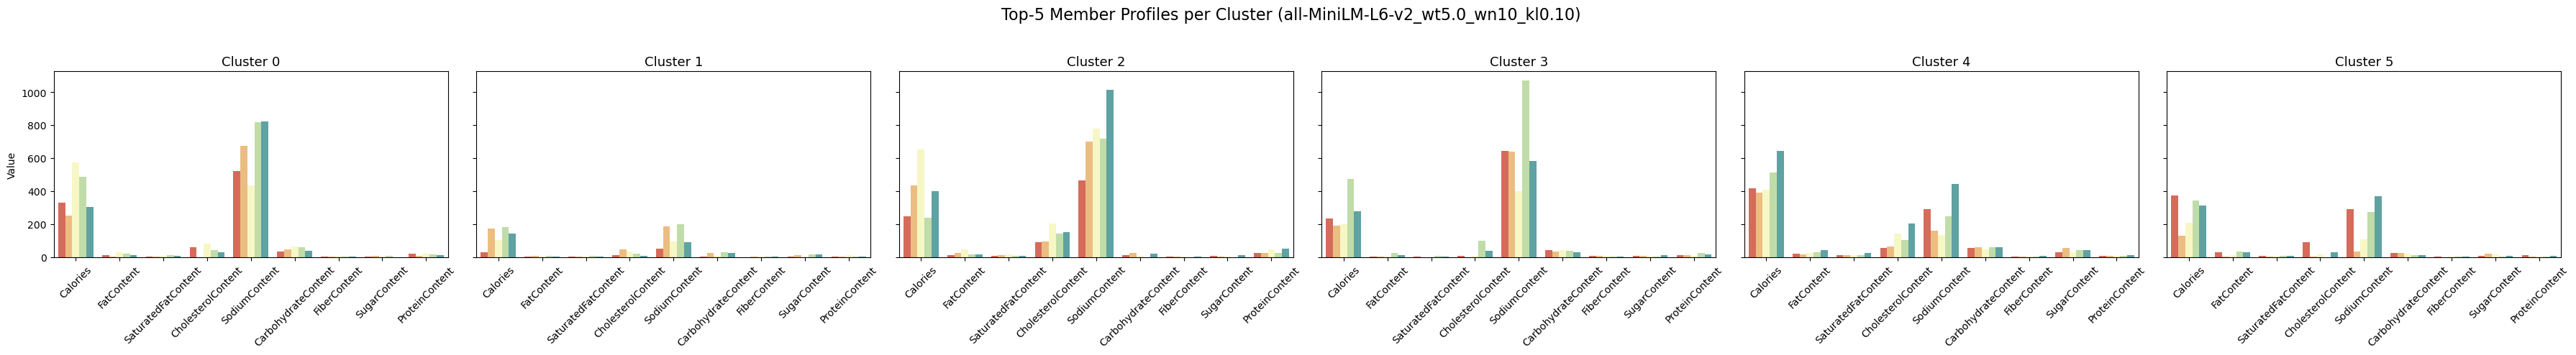

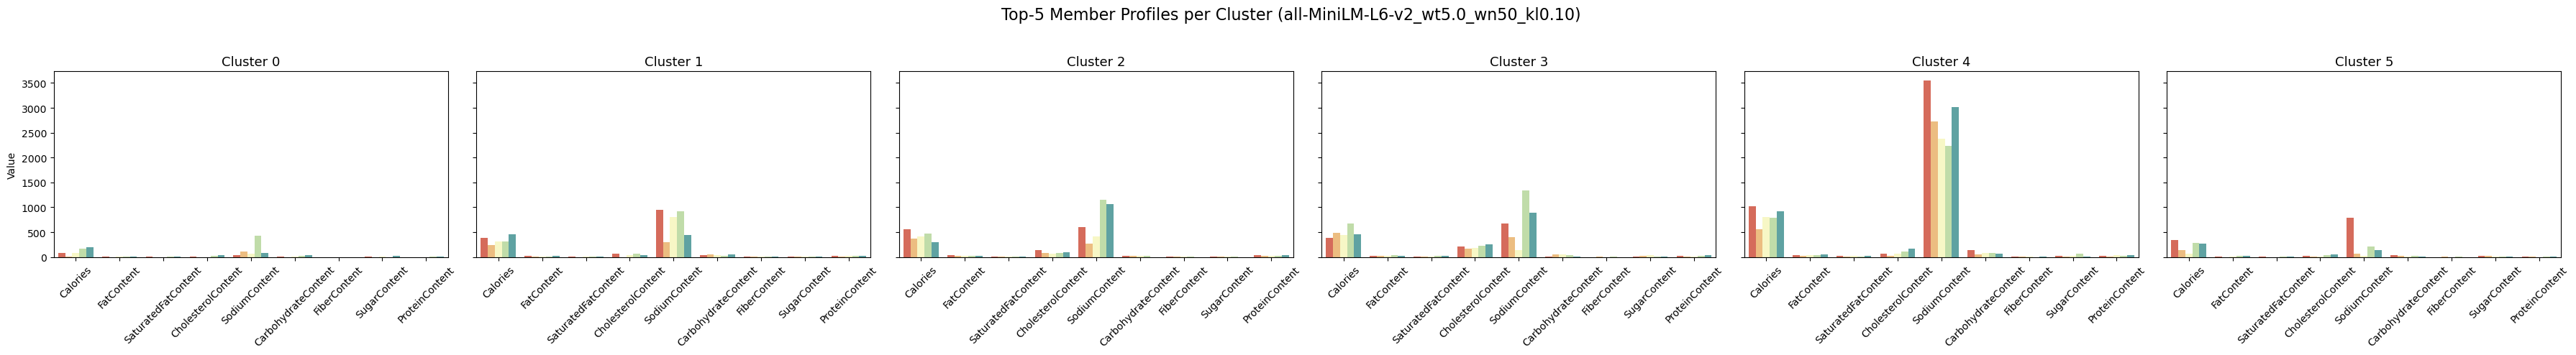

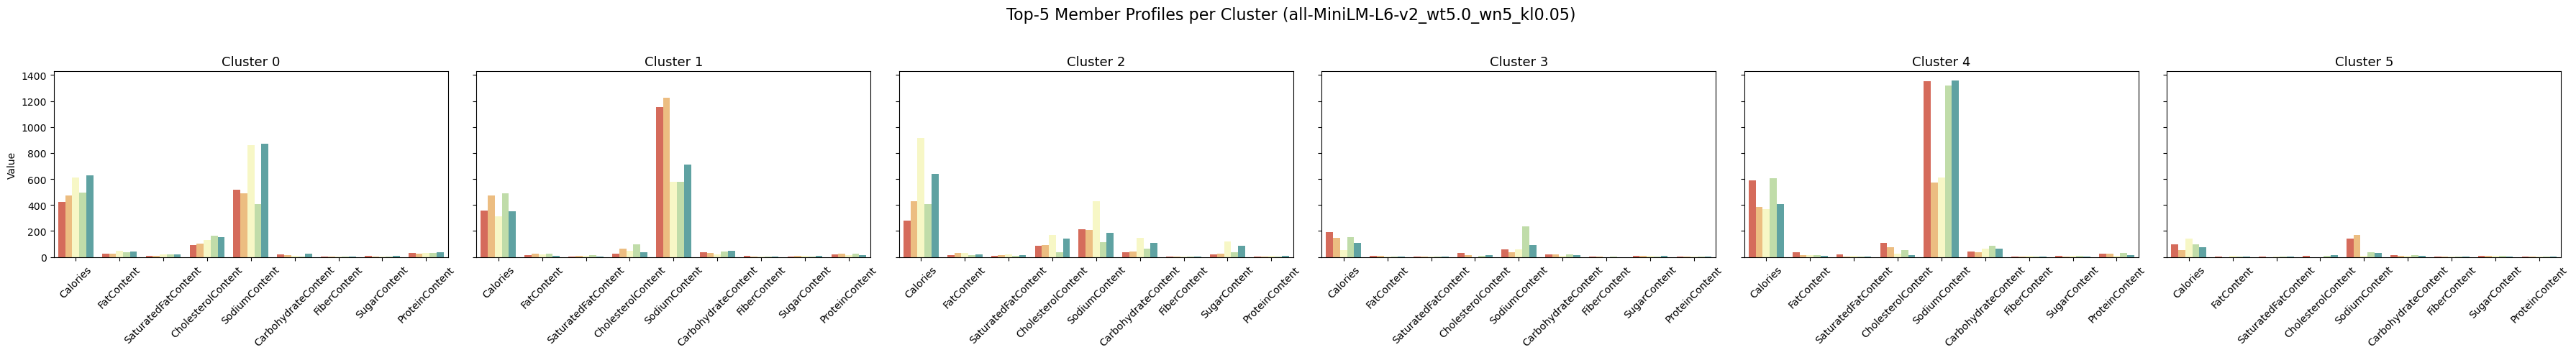

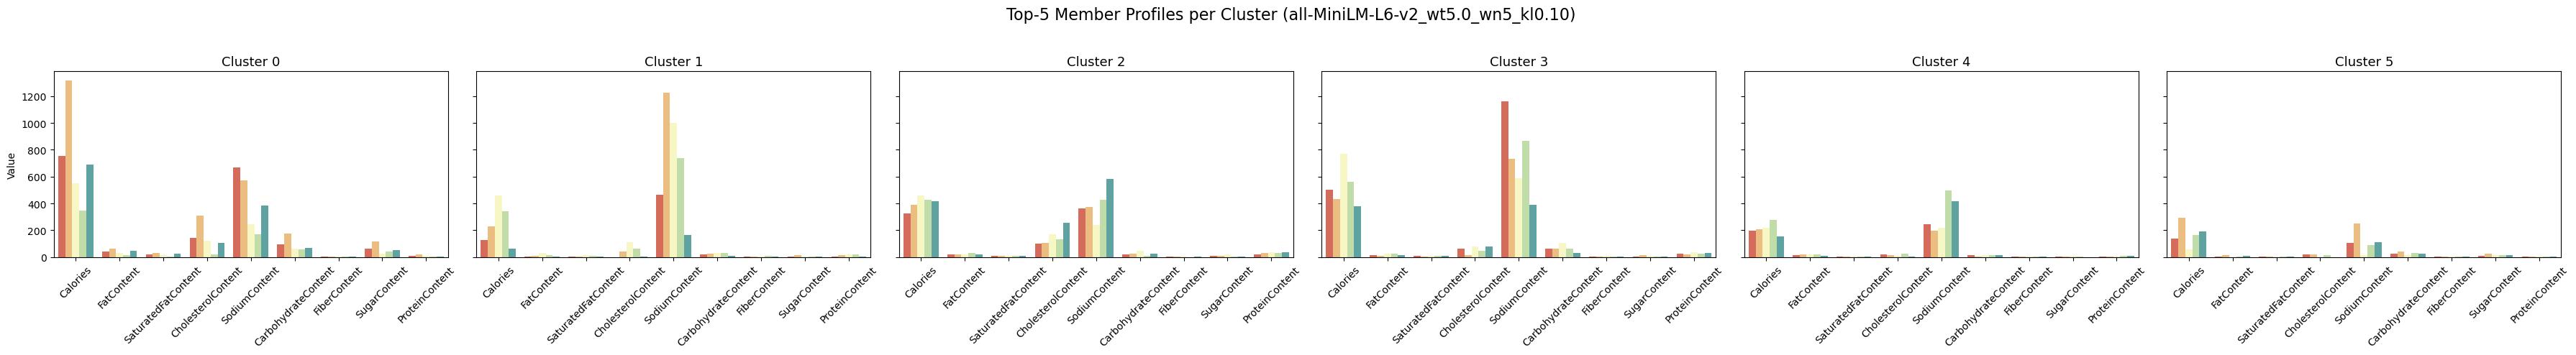

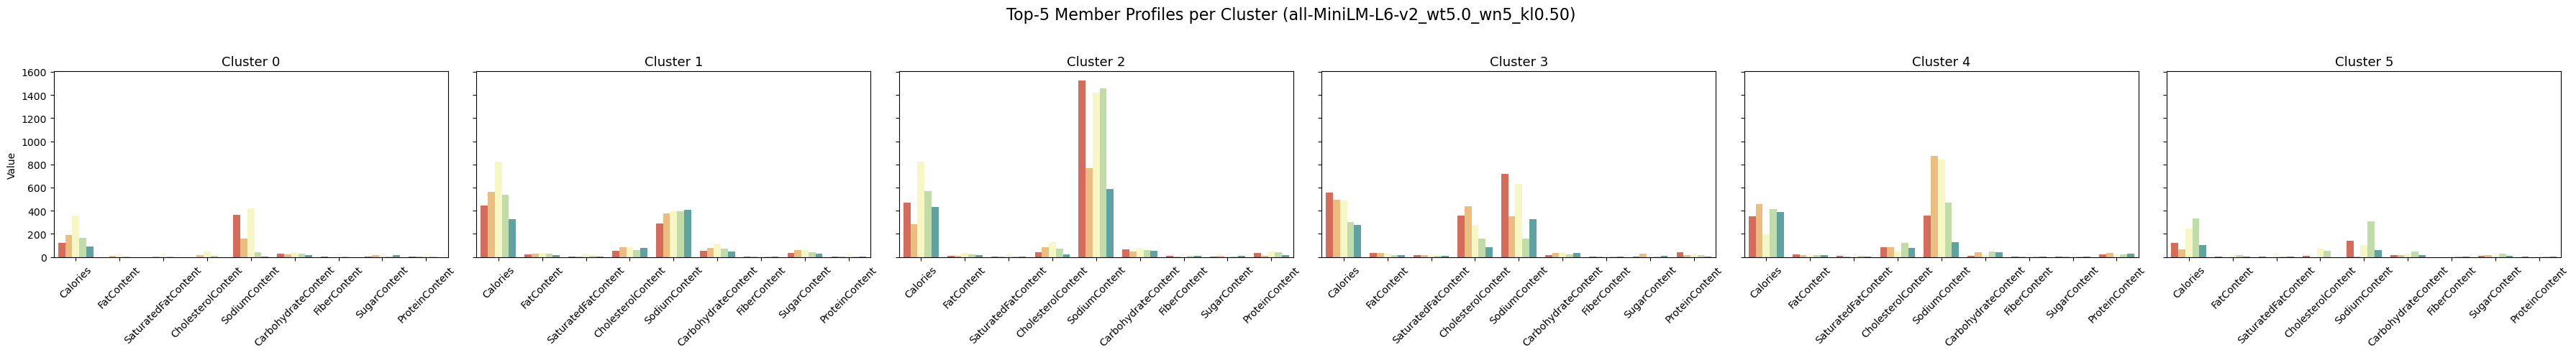

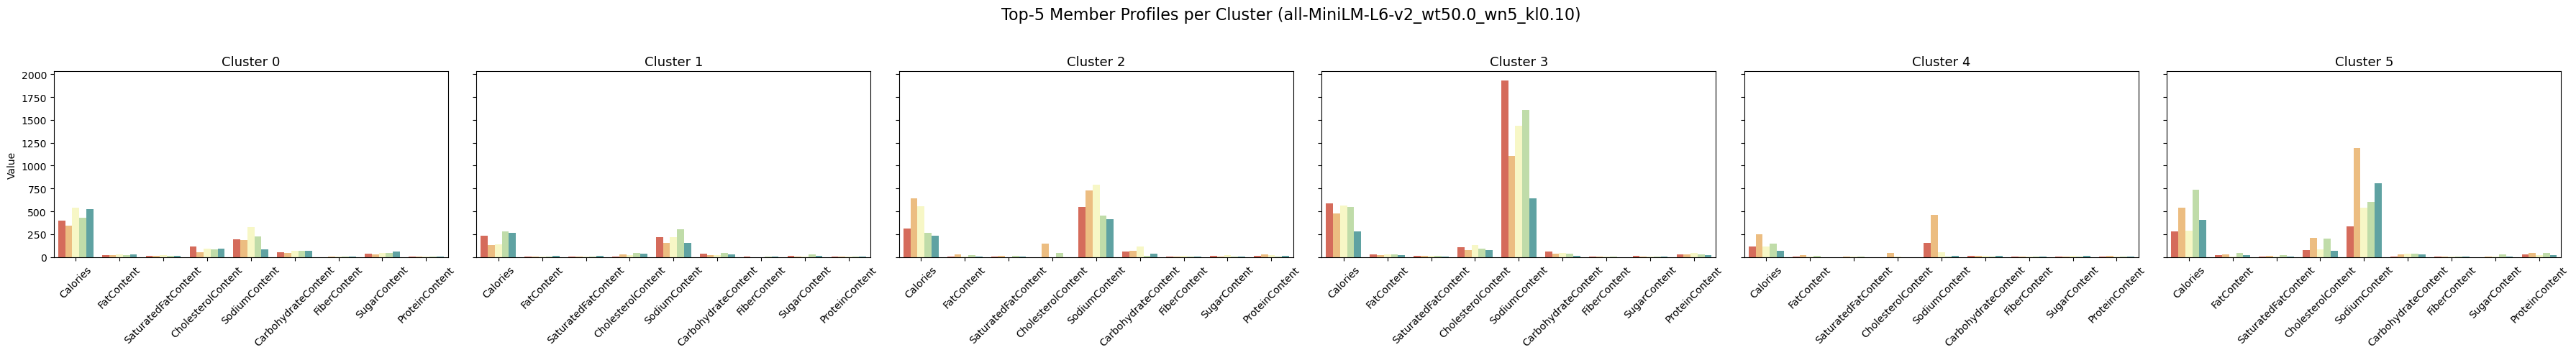

In [11]:
for k, v in profile_table.items():
    plot_all_clusters_top5_row(profile_table, k)

## Recipe Recommendation

All of the models above looks good except 3 that we will drop. We keep the remaining 6 models and for each new recipe, we will compute the 10 first recommeneded recipe from all the 6 models above and we suggest those that are predicted with all the remaining 6 models

In [12]:
for k , v in profile_table.items():
    print(k)

all-MiniLM-L6-v2_wt10.0_wn10_kl0.10
all-MiniLM-L6-v2_wt10.0_wn50_kl0.10
all-MiniLM-L6-v2_wt10.0_wn5_kl0.10
all-MiniLM-L6-v2_wt5.0_wn10_kl0.10
all-MiniLM-L6-v2_wt5.0_wn50_kl0.10
all-MiniLM-L6-v2_wt5.0_wn5_kl0.05
all-MiniLM-L6-v2_wt5.0_wn5_kl0.10
all-MiniLM-L6-v2_wt5.0_wn5_kl0.50
all-MiniLM-L6-v2_wt50.0_wn5_kl0.10


In [17]:
from collections import Counter
import numpy as np

good_models = [
    "all-MiniLM-L6-v2_wt10.0_wn10_kl0.10",
    "all-MiniLM-L6-v2_wt10.0_wn50_kl0.10",
    "all-MiniLM-L6-v2_wt10.0_wn5_kl0.10",
    "all-MiniLM-L6-v2_wt5.0_wn10_kl0.10",
    "all-MiniLM-L6-v2_wt5.0_wn5_kl0.05",
    "all-MiniLM-L6-v2_wt50.0_wn5_kl0.10"
]

random_test_recipe_ids = np.random.choice(test_recipes['RecipeId'], 10, replace=False)
threshold = 3  # minimum number of models that must recommend the recipe

for recipe_id in random_test_recipe_ids:
    # Get liked recipe info
    liked_recipe = test_recipes[test_recipes['RecipeId'] == recipe_id].iloc[0]
    print("\n" + "="*70)
    print(f"🍽️ Liked Recipe")
    print(f"ID: {recipe_id}")
    print(f"Name: {liked_recipe['Name']}")
    print(f"Instructions:\n{liked_recipe['RecipeInstructions']}\n")
    
    # Collect recommendations from all models
    model_recs = []
    for model_name in good_models:
        recs = get_cluster_recommendations(cluster_dict[model_name], test_recipes, recipe_id)
        top_ids = recs['RecipeId'].head(5).tolist()
        model_recs.extend(top_ids)
    
    # Count occurrences and filter by threshold
    rec_counts = Counter(model_recs)
    consensus_recs = [rid for rid, count in rec_counts.items() if count >= threshold]
    
    # Print suggested recipes info
    if consensus_recs:
        final_recs = test_recipes[test_recipes['RecipeId'].isin(consensus_recs)]
        print(f"✅ Recommended Recipes (appearing in at least {threshold} models):\n")
        for idx, row in final_recs.iterrows():
            print(f"📝 Recipe ID: {row['RecipeId']}")
            print(f"🍲 Name: {row['Name']}")
            print(f"📖 Instructions:\n{row['RecipeInstructions']}\n")
            print("-"*70)
    else:
        print(f"⚠️ No recipes reached the threshold of {threshold} model recommendations.")


🍽️ Liked Recipe
ID: 326591
Name: Golden Syrup Russian Fudge
Instructions:
c("Place all the ingredients except the vanilla, into a medium-heavy saucepan.", "Warm over a gentle heat until the sugar has dissolved.", "Bring to a gentle boil and cook for about 15 — 20 minutes stirring occasionally, until it reaches the soft ball stage (120°C).", "Remove from the heat and add the vanilla.", "Beat (I use an electric mixer) until the fudge is creamy and thick and has lost its gloss for about 4 minutes.", "Pour into a greased 20 cm cake pan.", "Allow to cold and harden.", "Enjoy!"
)

✅ Recommended Recipes (appearing in at least 3 models):

📝 Recipe ID: 518256
🍲 Name: &ldquo;White Caprese&quot; Cake Gluten Free
📖 Instructions:
c("Blitz in the mixer almonds till very small pieces but not too thin (like almond flour). Set aside.If you have almonds with skin, boil them for 5 minutes to peel them easily.", "Melt chopped white chocolate in microwave oven or in a small pot over a bigger one  with boi